In [1]:
import numpy as np
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

%matplotlib inline

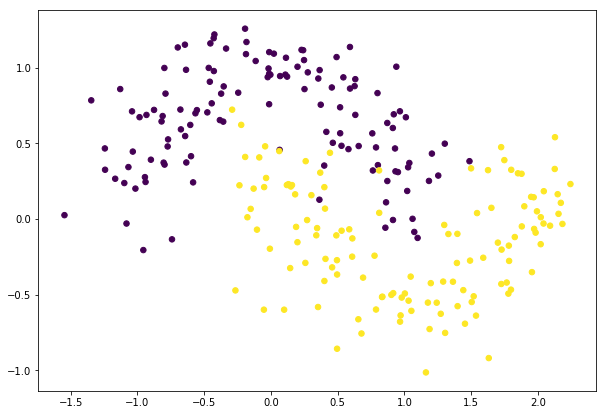

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = make_moons(250, noise=0.20)
plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], s=30, c=y, cmap=m)

In [3]:
# Train the logistic rgeression classifier
logreg_clf = LogisticRegressionCV()
logreg_clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [4]:
def plot_decision_boundary(predict):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .25, X[:, 0].max() + .25
    y_min, y_max = X[:, 1].min() - .25, X[:, 1].max() + .25
    h = 0.007
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral_r)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral_r)

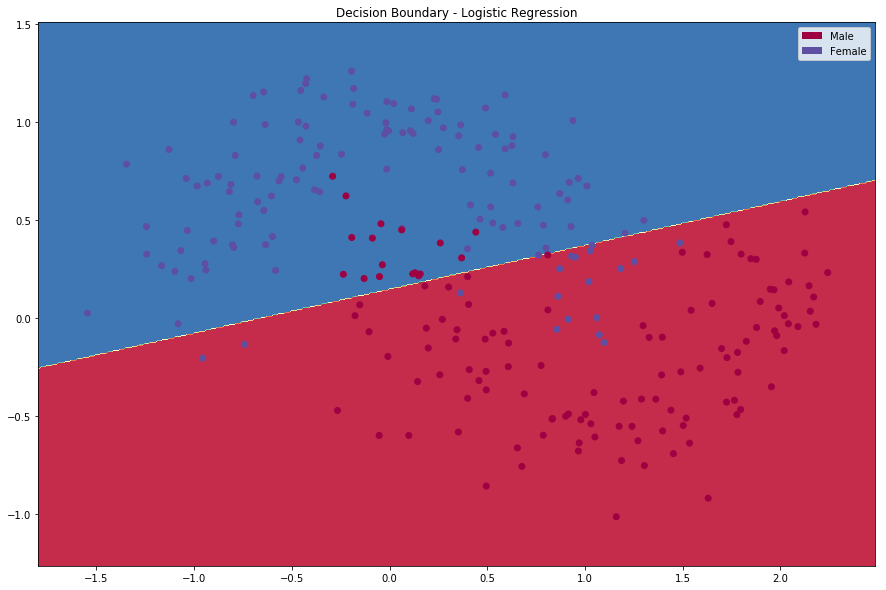

In [5]:
# Plot the decision boundary
plt.figure(figsize=(15, 10))
plot_decision_boundary(lambda x: logreg_clf.predict(x))
plt.title("Decision Boundary - Logistic Regression")

classes = ['Male','Female']
class_colours = [plt.cm.get_cmap('Spectral')(0), plt.cm.get_cmap('Spectral_r')(0)]
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
plt.legend(recs, classes, loc=1)

In [6]:
def my_tanh(array, backward=False):
    if backward:
        return (1 - np.power(array, 2))
    return np.tanh(array)

In [7]:
def my_sigmoid(array, backward=False):
    if backward:
        s = my_sigmoid(array)
        return s*(1 - s)
    return 1 / (1 + np.exp(-array))

In [8]:
def my_relu(array, hidden_values=None, backward=False):
    if backward and hidden_values is not None:
        array[hidden_values <= 0] = 0
        return array
    return np.maximum(0, array)

In [9]:
def my_softmax(array):
    array -= np.max(array, axis=1).reshape(-1, 1) #remove the max to avoid exp overflow
    ex = np.exp(array)
    return ex / np.sum(ex, axis=1, keepdims=True)

In [10]:
def forward_pass(model, X):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = X.dot(W1) + b1
    a1 = my_relu(z1)
    z2 = a1.dot(W2) + b2
    return my_softmax(z2), a1

In [11]:
def calc_loss(model, X, y, reg):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    probs, _ = forward_pass(model, X)
    correct_logprobs = -np.log(probs[range(len(X)), y])
    data_loss = np.sum(correct_logprobs)
    reg_loss = reg / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    loss = data_loss + reg_loss
    return loss / len(X)

In [12]:
def predict(model, X):
    probs, _ = forward_pass(model, X)
    return np.argmax(probs, axis=1)

In [13]:
def show_legend():
    classes = ['Male','Pred male', 'Female', 'Pred female']
    class_colours = [plt.cm.get_cmap('Spectral')(0), plt.cm.get_cmap('binary_r')(0),
                     plt.cm.get_cmap('Spectral_r')(0), plt.cm.get_cmap('binary')(0)]
    recs = []
    for i in range(len(class_colours)):
        recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
    return plt.legend(recs, classes, loc=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [15]:
input_size = 2 # input layer dimensionality -> position in the plane
output_size = 2 # output layer dimensionality -> male/female

def make_model(X, y, epochs, hidden_size, decay=None, batch_size=None, print_loss=None, lr=0.02, reg=0.01):

    def get_mini_batch(X, y, n_train, batch_size):
        mask = np.random.choice(a=n_train, size=batch_size, replace=False)
        return X[mask], y[mask]
    
    if batch_size is not None:
        N = batch_size
    else:
        N = len(X) # training set size 
        
    model = {}

    # tanh
    model['W1'] = np.random.randn(input_size, hidden_size) / np.sqrt(input_size)
    model['W2'] = np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size)

    # ReLU
    #model['W1'] = np.random.randn(input_size, hidden_size) * np.sqrt(2/N)
    #model['W2'] = np.random.randn(hidden_size, output_size) * np.sqrt(2/N)
    model['b1'] = np.zeros((1, hidden_size))
    model['b2'] = np.zeros((1, output_size))
    
    # Sigmoid
    #model['W1'] = 1e-4 * np.random.randn(input_size, hidden_size)
    #model['W2'] = 1e-4 * np.random.randn(hidden_size, output_size)
    
    for i in range(epochs):
        if batch_size is not None:
            X, y = get_mini_batch(X, y, N, batch_size)
    
        # Forward
        probs, a1 = forward_pass(model, X)

        # Backward
        delta3 = probs
        delta3[range(N), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(model['W2'].T) 
        delta2 = my_relu(delta2, a1, backward=True)
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (weights only)
        dW2 += reg * model['W2']
        dW1 += reg * model['W1']

        # LR decay
        if decay is not None:
            ratio, iterations = decay
            if i % iterations == 0:
                if 0 < ratio < 1:
                    lr -= lr * ratio
        
        # Gradient descent parameter update
        model['W1'] += -lr * dW1
        model['b1'] += -lr * db1
        model['W2'] += -lr * dW2
        model['b2'] += -lr * db2

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss is not None and i % print_loss == 0:
          print("Loss after iteration %i: %f" %(i, calc_loss(model, X_train, y_train, reg=reg)))
    return model

In [24]:
model = make_model(X_train, y_train, lr=0.01, print_loss=5000, epochs=55001, hidden_size=11)

Loss after iteration 0: 0.417061
Loss after iteration 5000: 0.058574
Loss after iteration 10000: 0.057274
Loss after iteration 15000: 0.056603
Loss after iteration 20000: 0.058001
Loss after iteration 25000: 0.058027
Loss after iteration 30000: 0.056467
Loss after iteration 35000: 0.057082
Loss after iteration 40000: 0.056992
Loss after iteration 45000: 0.057385
Loss after iteration 50000: 0.057606
Loss after iteration 55000: 0.056981


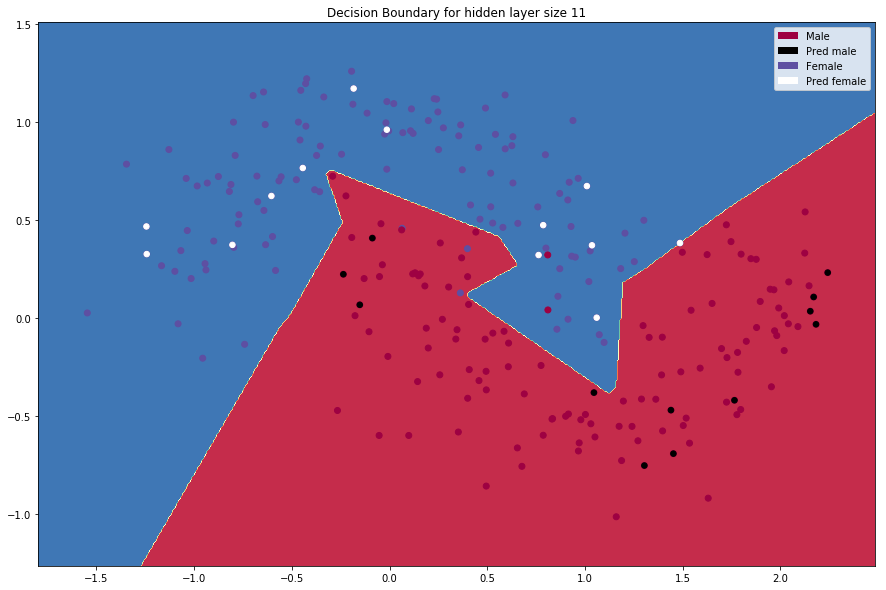

In [25]:
predictions = predict(model, X_test)
plt.figure(figsize=(15, 10))
plot_decision_boundary(lambda x: predict(model, x))
plt.scatter(X_test[:,0], X_test[:,1], s=30, c=predictions, cmap=plt.cm.binary)
plt.title("Decision Boundary for hidden layer size 11")
show_legend()

Loss after iteration 0: 0.541957
Loss after iteration 5000: 0.346627
Loss after iteration 10000: 0.346598
Loss after iteration 15000: 0.346634
Loss after iteration 20000: 0.346606
Loss after iteration 25000: 0.346643
Loss after iteration 30000: 0.346650
Loss after iteration 35000: 0.346626
Loss after iteration 40000: 0.346645
Loss after iteration 45000: 0.346623
Loss after iteration 50000: 0.346643
Loss after iteration 0: 0.567505
Loss after iteration 5000: 0.309063
Loss after iteration 10000: 0.315728
Loss after iteration 15000: 0.315878
Loss after iteration 20000: 0.314517
Loss after iteration 25000: 0.314959
Loss after iteration 30000: 0.315410
Loss after iteration 35000: 0.315863
Loss after iteration 40000: 0.314524
Loss after iteration 45000: 0.314998
Loss after iteration 50000: 0.315462
Loss after iteration 0: 0.723422
Loss after iteration 5000: 0.371933
Loss after iteration 10000: 0.329879
Loss after iteration 15000: 0.314296
Loss after iteration 20000: 0.304073
Loss after itera

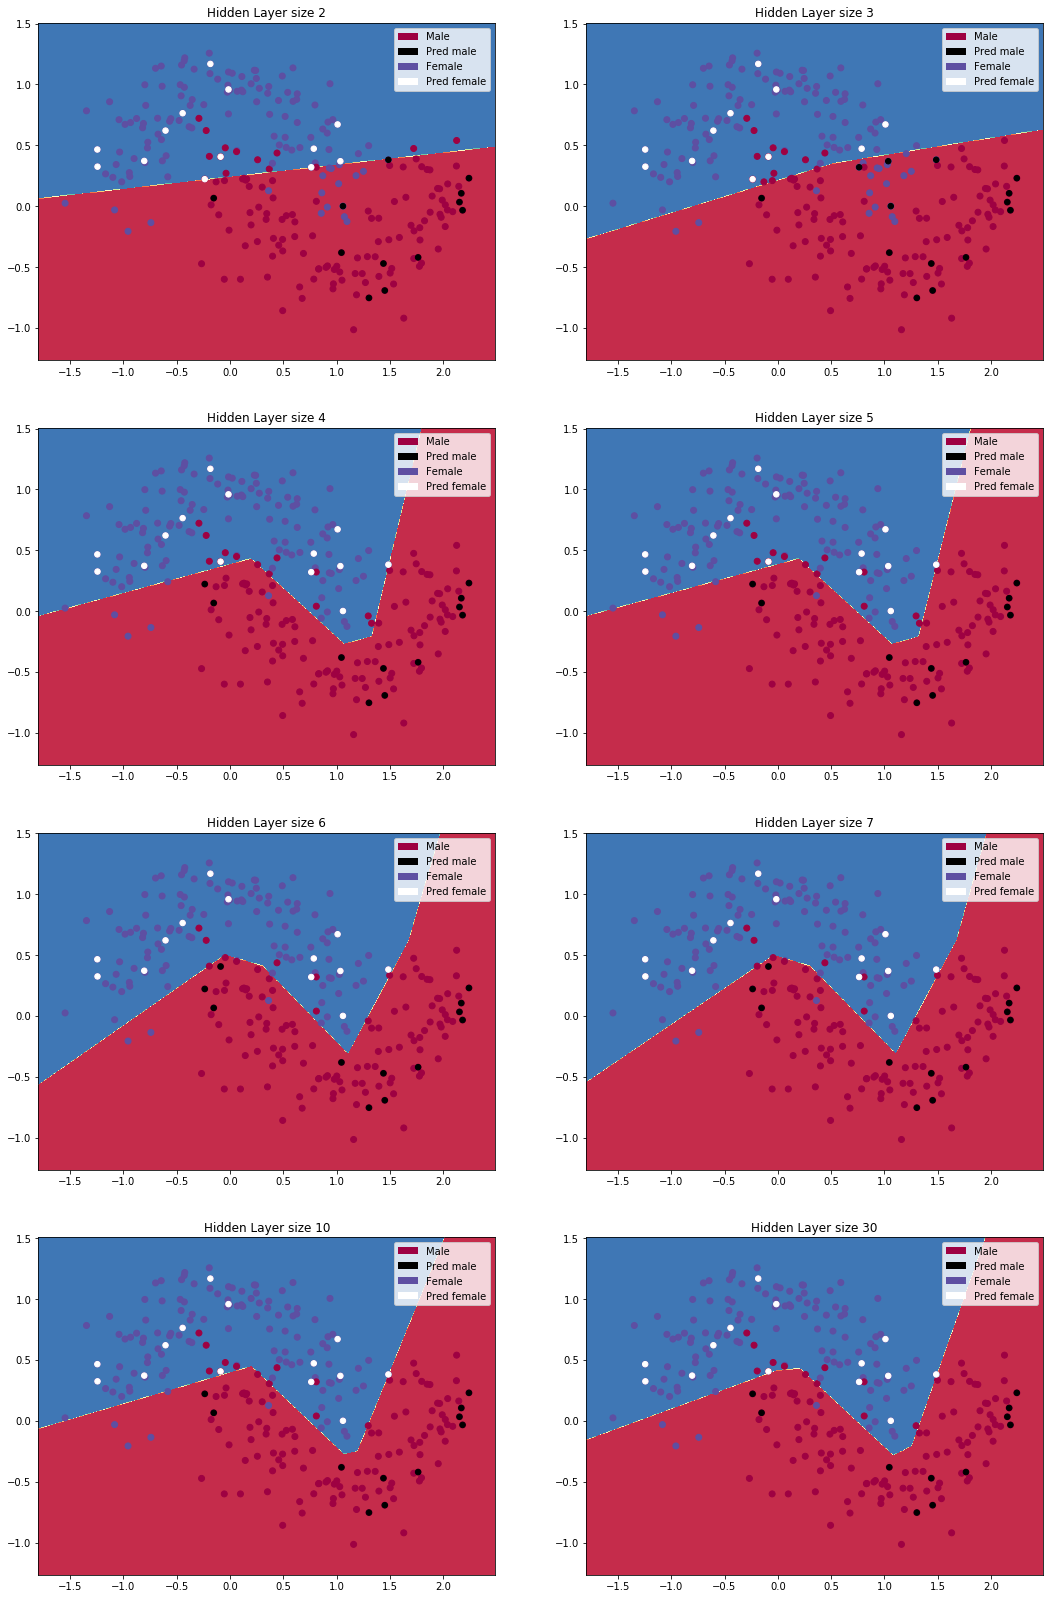

In [23]:
plt.figure(figsize=(18, 36))
hidden_sizes = [2, 3, 4, 5, 6, 7, 10, 30]

for i, hidden_size in enumerate(hidden_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % hidden_size)
    model = make_model(X_train, y_train, 50001, hidden_sizes[i], lr=0.01, batch_size=32, print_loss=5000)
    predictions = predict(model, X_test)
    plot_decision_boundary(lambda x: predict(model, x))
    plt.scatter(X_test[:,0], X_test[:,1], s=30, c=predictions, cmap=plt.cm.binary)
    show_legend()
plt.show()

Loss after iteration 0: 0.464510
Loss after iteration 5000: 0.295826
Loss after iteration 10000: 0.296435
Loss after iteration 15000: 0.297606
Loss after iteration 20000: 0.298229
Loss after iteration 25000: 0.298016
Loss after iteration 30000: 0.298472
Loss after iteration 35000: 0.298865
Loss after iteration 40000: 0.298018
Loss after iteration 45000: 0.299048
Loss after iteration 50000: 0.297467
Loss after iteration 0: 2.326334
Loss after iteration 5000: 0.262501
Loss after iteration 10000: 0.260853
Loss after iteration 15000: 0.260715
Loss after iteration 20000: 0.261945
Loss after iteration 25000: 0.260743
Loss after iteration 30000: 0.260815
Loss after iteration 35000: 0.261042
Loss after iteration 40000: 0.260062
Loss after iteration 45000: 0.260634
Loss after iteration 50000: 0.260351
Loss after iteration 0: 0.627973
Loss after iteration 5000: 0.303851
Loss after iteration 10000: 0.292653
Loss after iteration 15000: 0.285611
Loss after iteration 20000: 0.282543
Loss after itera

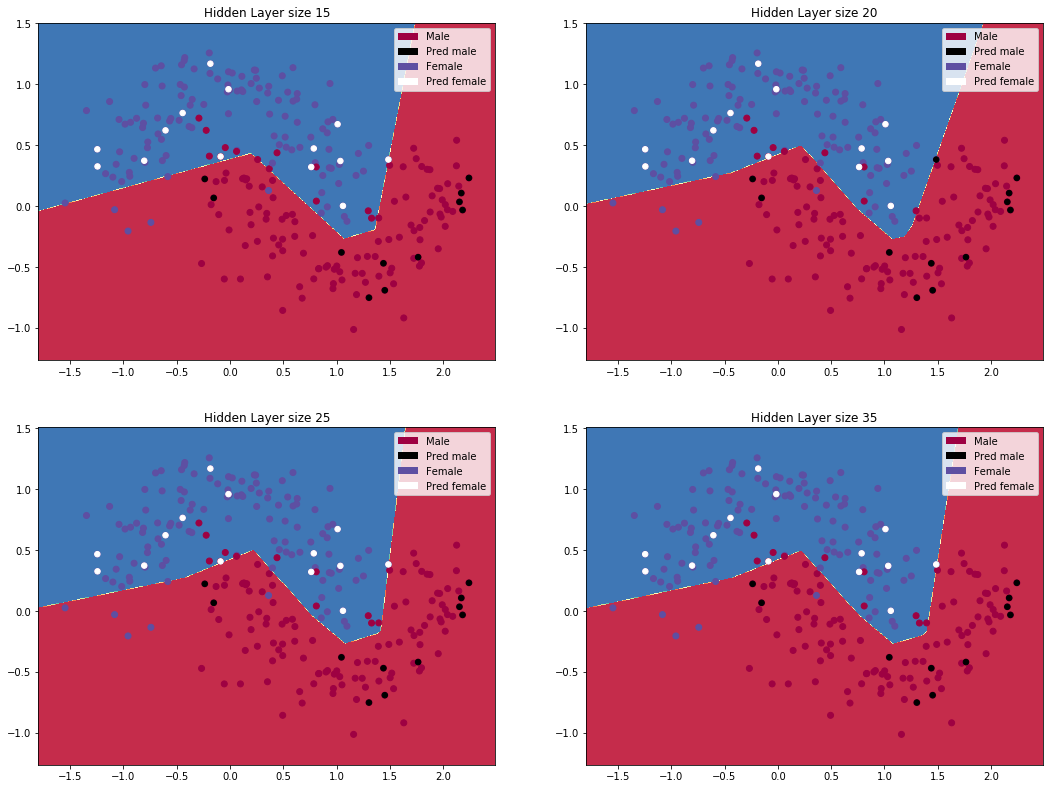

In [19]:
plt.figure(figsize=(18, 36))
hidden_sizes = [15, 20, 25, 35]

for i, hidden_size in enumerate(hidden_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % hidden_size)
    model = make_model(X_train, y_train, 50001, hidden_sizes[i], lr=0.1, decay=(0.01, 1000), batch_size=32, print_loss=5000)
    predictions = predict(model, X_test)
    plot_decision_boundary(lambda x: predict(model, x))
    plt.scatter(X_test[:,0], X_test[:,1], s=30, c=predictions, cmap=plt.cm.binary)
    show_legend()
plt.show()

Loss after iteration 0: 0.702421
Loss after iteration 5000: 0.252744
Loss after iteration 10000: 0.600867
Loss after iteration 15000: 0.835716
Loss after iteration 20000: 0.902130
Loss after iteration 25000: 0.925807
Loss after iteration 30000: 0.917411
Loss after iteration 35000: 0.914262
Loss after iteration 40000: 0.900695
Loss after iteration 45000: 0.870738
Loss after iteration 50000: 0.845729
Loss after iteration 0: 1.087755
Loss after iteration 5000: 0.268075
Loss after iteration 10000: 0.357462
Loss after iteration 15000: 0.400521
Loss after iteration 20000: 0.446999
Loss after iteration 25000: 0.461553
Loss after iteration 30000: 0.470189
Loss after iteration 35000: 0.467292
Loss after iteration 40000: 0.467864
Loss after iteration 45000: 0.466440
Loss after iteration 50000: 0.466907
Loss after iteration 0: 0.438642
Loss after iteration 5000: 0.253729
Loss after iteration 10000: 0.537721
Loss after iteration 15000: 0.715838
Loss after iteration 20000: 0.779870
Loss after itera

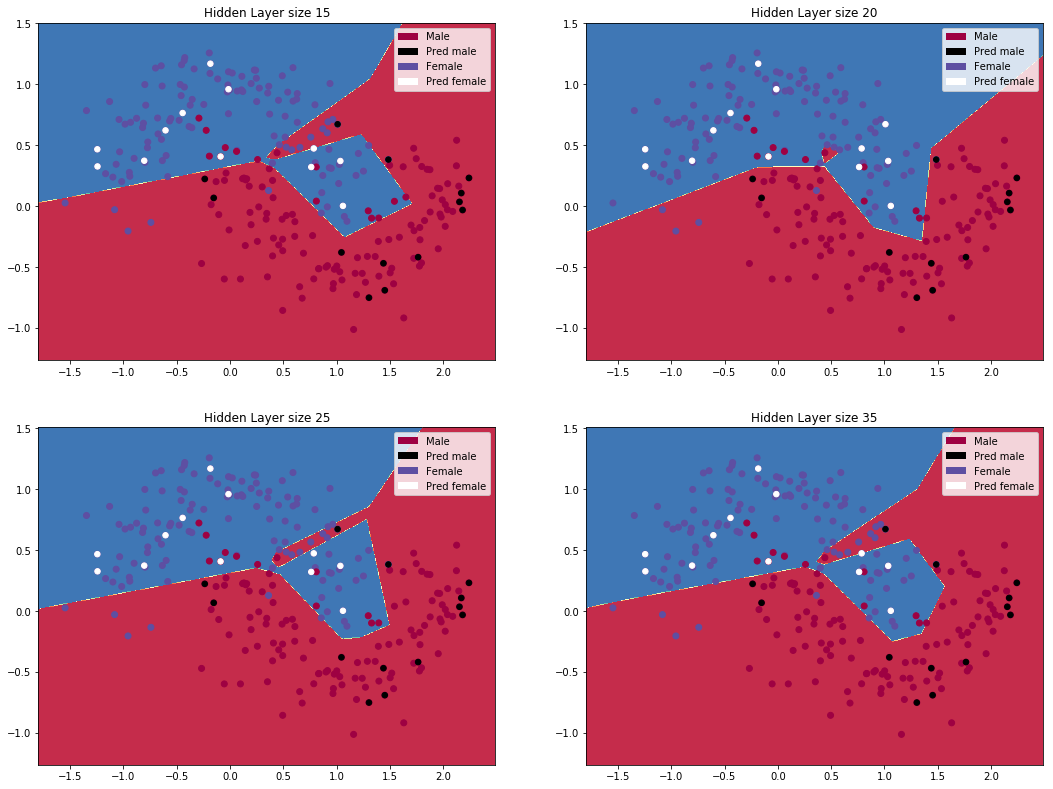

In [22]:
plt.figure(figsize=(18, 36))
hidden_sizes = [15, 20, 25, 35]

for i, hidden_size in enumerate(hidden_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % hidden_size)
    model = make_model(X_train, y_train, 50001, hidden_sizes[i], lr=0.01, batch_size=64, print_loss=5000)
    predictions = predict(model, X_test)
    plot_decision_boundary(lambda x: predict(model, x))
    plt.scatter(X_test[:,0], X_test[:,1], s=30, c=predictions, cmap=plt.cm.binary)
    show_legend()
plt.show()

Loss after iteration 0: 0.579476
Loss after iteration 5000: 0.072586
Loss after iteration 10000: 0.067317
Loss after iteration 15000: 0.067500
Loss after iteration 20000: 0.067672
Loss after iteration 25000: 0.068156
Loss after iteration 30000: 0.069912
Loss after iteration 35000: 0.068644
Loss after iteration 40000: 0.068334
Loss after iteration 45000: 0.069269
Loss after iteration 50000: 0.068851
Loss after iteration 0: 0.488468
Loss after iteration 5000: 0.059060
Loss after iteration 10000: 0.055033
Loss after iteration 15000: 0.054233
Loss after iteration 20000: 0.054808
Loss after iteration 25000: 0.052527
Loss after iteration 30000: 0.051999
Loss after iteration 35000: 0.054814
Loss after iteration 40000: 0.051294
Loss after iteration 45000: 0.055287
Loss after iteration 50000: 0.052355
Loss after iteration 0: 1.009915
Loss after iteration 5000: 0.058251
Loss after iteration 10000: 0.056250
Loss after iteration 15000: 0.057276
Loss after iteration 20000: 0.055085
Loss after itera

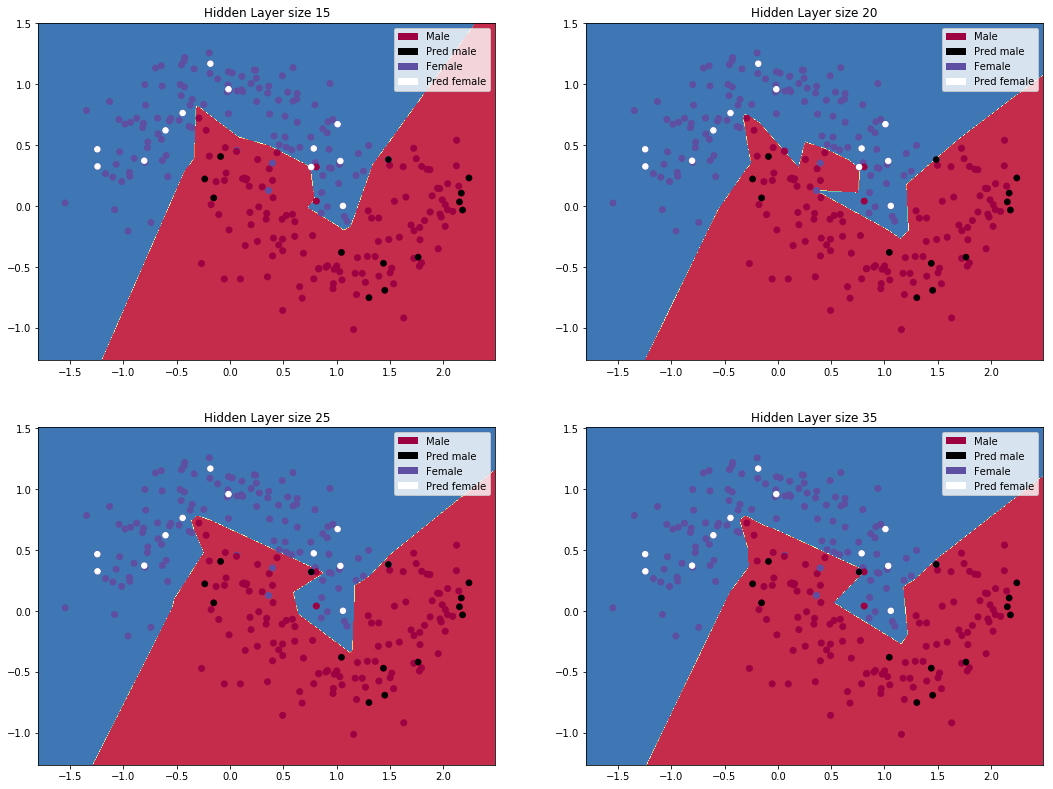

In [26]:
plt.figure(figsize=(18, 36))
hidden_sizes = [15, 20, 25, 35]

for i, hidden_size in enumerate(hidden_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % hidden_size)
    model = make_model(X_train, y_train, 50001, hidden_sizes[i], lr=0.01, print_loss=5000)
    predictions = predict(model, X_test)
    plot_decision_boundary(lambda x: predict(model, x))
    plt.scatter(X_test[:,0], X_test[:,1], s=30, c=predictions, cmap=plt.cm.binary)
    show_legend()
plt.show()

Loss after iteration 0: 0.438238
Loss after iteration 5000: 0.066467
Loss after iteration 10000: 0.065914
Loss after iteration 15000: 0.068473
Loss after iteration 20000: 0.067015
Loss after iteration 25000: 0.068010
Loss after iteration 30000: 0.070463
Loss after iteration 35000: 0.069455
Loss after iteration 40000: 0.068210
Loss after iteration 45000: 0.067988
Loss after iteration 50000: 0.067445
Loss after iteration 0: 0.585552
Loss after iteration 5000: 0.060505
Loss after iteration 10000: 0.056406
Loss after iteration 15000: 0.058903
Loss after iteration 20000: 0.057126
Loss after iteration 25000: 0.057288
Loss after iteration 30000: 0.059088
Loss after iteration 35000: 0.053829
Loss after iteration 40000: 0.054665
Loss after iteration 45000: 0.054647
Loss after iteration 50000: 0.056831
Loss after iteration 0: 3.155764
Loss after iteration 5000: 0.056904
Loss after iteration 10000: 0.056529
Loss after iteration 15000: 0.055745
Loss after iteration 20000: 0.053766
Loss after itera

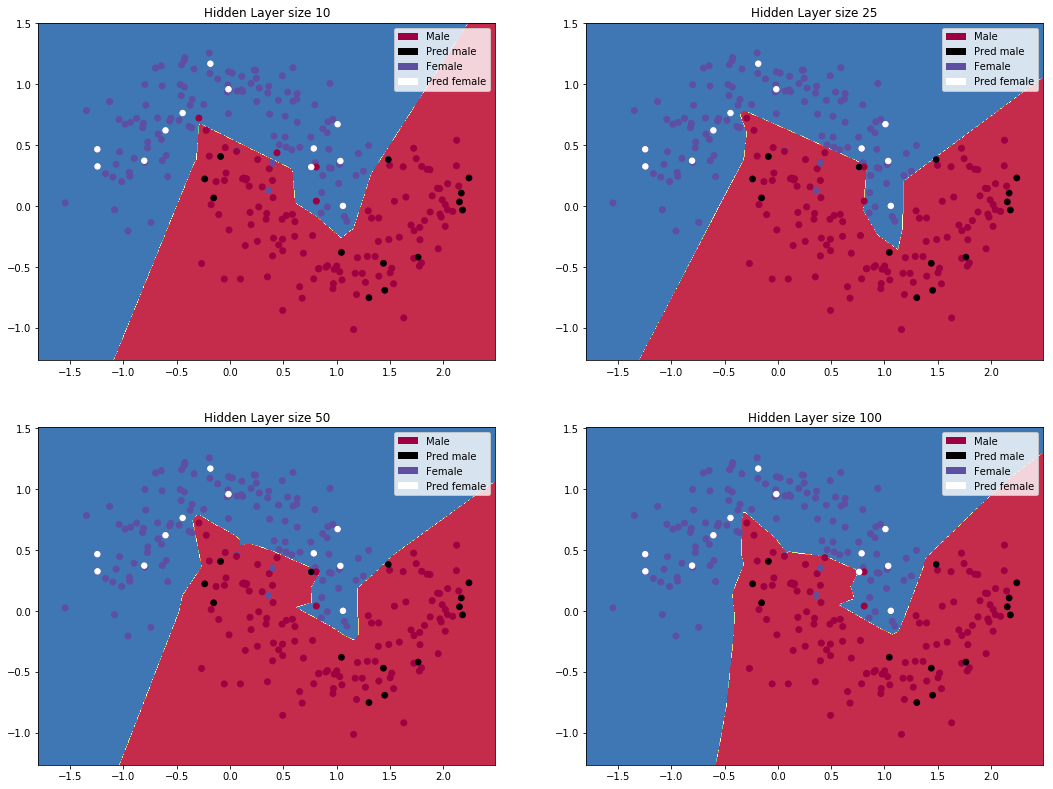

In [21]:
# Full batch and lower lr

plt.figure(figsize=(18, 36))
hidden_sizes = [10, 25, 50, 100]

for i, hidden_size in enumerate(hidden_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % hidden_size)
    model = make_model(X_train, y_train, 50001, hidden_sizes[i], lr=0.01, print_loss=5000)
    predictions = predict(model, X_test)
    plot_decision_boundary(lambda x: predict(model, x))
    plt.scatter(X_test[:,0], X_test[:,1], s=30, c=predictions, cmap=plt.cm.binary)
    show_legend()
plt.show()